## 모멘텀 팩터 롱텀: 지난 1년 간의 주가정보 수집 -> positive 종목 중 5개 추천

In [4]:
import pandas as pd
from datetime import date, datetime, timedelta
import pandas as pd
import time
import numpy as np

import FinanceDataReader as fdr
# from pykrx import stock

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# %matplotlib inline


In [5]:
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="./malgun.ttf").get_name()
rc('font', family=font_name)

In [6]:
recommendationCount = 5

In [7]:
def getMomentum(tickersDF, startDate, endDate):
    positiveTickers = []
    for eachTicker in tickersDF.Ticker:
        eachPriceForYearDF = fdr.DataReader(symbol = eachTicker, start = startDate, end = endDate)
        # 부동산 ticker 배제
        if not eachPriceForYearDF.empty:
            # 시작일 기준 3달 간의 수익률 계산
            eachYield = (eachPriceForYearDF.Close[-1] - eachPriceForYearDF.Close[0]) / eachPriceForYearDF.Close[0]
            eachStd = np.std(eachPriceForYearDF.Close)
            eachAdjustedYield = eachYield / eachStd
            if (eachYield > 0):
                eachPositiveTickers = []
                eachPositiveTickers.append(eachTicker)
                eachPositiveTickers.append(eachYield)
                eachPositiveTickers.append(eachStd)
                eachPositiveTickers.append(eachAdjustedYield)
                positiveTickers.append(eachPositiveTickers)
            else:
                pass
        else:
#             print(eachTicker + " is a real estate")
            pass
            
    positiveTickersDF = pd.DataFrame(positiveTickers, columns = ["Ticker", "Yield", "Std", "AdjustedYield"])
    positiveTickersDF = positiveTickersDF[positiveTickersDF.AdjustedYield != float("inf")]
    positiveTickersDF.sort_values("AdjustedYield", ascending=False, ignore_index=True, inplace=True)
    
    return positiveTickersDF

In [8]:
def getRcmdDFByYield(commonStockTickersDf, positiveTickersDF, targetMarket):
    commonStockTickersDF = pd.merge(commonStockTickersDf, positiveTickersDF, how="inner")
    if (targetMarket == "KRX"):
        rcmdDF = commonStockTickersDF.sort_values("Yield", ascending=False, ignore_index=True)[:recommendationCount]
    else:
        tmpDF = commonStockTickersDf[commonStockTickersDf.Market == targetMarket]
        tmpDF = pd.merge(tmpDF, positiveTickersDF, how="inner")
        rcmdDF = tmpDF.sort_values("Yield", ascending=False, ignore_index=True)[:recommendationCount]
    return rcmdDF

In [9]:
# 보통주만 발라내서 추천
def getRcmdDFByAdjustedYield(commonStockTickersDf, positiveTickersDF, targetMarket):
    commonStockTickersDF = pd.merge(commonStockTickersDf, positiveTickersDF, how="inner")
    if (targetMarket == "KRX"):
        rcmdDF = commonStockTickersDF.sort_values("AdjustedYield", ascending=False, ignore_index=True)[:recommendationCount]
    else:
        tmpDF = commonStockTickersDf[commonStockTickersDf.Market == targetMarket]
        tmpDF = pd.merge(tmpDF, positiveTickersDF, how="inner")
        rcmdDF = tmpDF.sort_values("AdjustedYield", ascending=False, ignore_index=True)[:recommendationCount]
    return rcmdDF

In [10]:
def getTickersDF(targetDate):
    tickersDF = pd.read_csv("./tickersDF.csv", encoding="ms949", dtype = {"Ticker":str}, index_col=False)
    tickersDF = tickersDF[tickersDF.Sector.notnull()].reset_index(drop=True)
    dropList = []
    tmpIndex = 0
    for eachListingDate in tickersDF.ListingDate:
        if (datetime.strptime(eachListingDate, "%Y-%m-%d") + timedelta(targetDate) > nowDate):
            dropList.append(tmpIndex)
        else :
            pass
        tmpIndex = tmpIndex + 1
    tickersDF = tickersDF.drop(index = dropList).reset_index(drop=True)
    return tickersDF

### 1. 기초정보 수집

In [11]:
# nowDate = datetime.today().strftime("%Y%m%d")

nowDate = datetime.today()

startDate = (nowDate - timedelta(365)).strftime("%Y%m%d")
endDate = (nowDate - timedelta(1)).strftime("%Y%m%d")

testStartDate = (nowDate - timedelta(730)).strftime("%Y%m%d")
testEndDate = (nowDate - timedelta(366)).strftime("%Y%m%d")

today = nowDate.strftime("%Y%m%d")

In [12]:
tickersDF = getTickersDF(366)
tickersDF.tail(1)

FileNotFoundError: [Errno 2] No such file or directory: './tickersDF.csv'

### 2. 추천종목 5개 선별 (KRX, KOSPI, KOSDAQ, KONEX : 보통주식)

In [10]:
positiveTickersDF = getMomentum(tickersDF, startDate, endDate)

C:\Users\kkuno\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


<!-- ### 추천종목 : 5개(KRX, 모든 주식) -->

In [11]:
# Yield 기준 추천 5개
krxRcmdDFByYield = getRcmdDFByYield(tickersDF, positiveTickersDF, "KRX")
kospiRcmdDFByYield = getRcmdDFByYield(tickersDF, positiveTickersDF, "KOSPI")
kosdaqRcmdDFByYield = getRcmdDFByYield(tickersDF, positiveTickersDF, "KOSDAQ")
konexRcmdDFByYield = getRcmdDFByYield(tickersDF, positiveTickersDF, "KONEX")

In [12]:
krxRcmdDFByYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,101360,KONEX,이엔드디,기타 화학제품 제조업,"매연저감장치, 촉매",2013-07-01,12월,김민용,http://www.endss.com,충청북도,13.545455,3275.872228,0.004135
1,227420,KONEX,도부마스크,기타 전문 도매업,1) 마스크 도소매업 2) 모바일 사업 및 R&D,2016-12-28,12월,김충범,http://www.dobumask.asia,서울특별시,9.632603,531.376720,0.018128
2,196170,KOSDAQ,알테오젠,자연과학 및 공학 연구개발업,바이오시밀러 및 바이오베터,2014-12-12,12월,박순재,http://www.alteogen.com,대전광역시,6.884615,68023.080345,0.000101
3,058110,KOSDAQ,멕아이씨에스,의료용 기기 제조업,인공호흡기,2015-12-14,12월,김종철,http://www.mek-ics.com,경기도,4.840909,8235.241682,0.000588
4,101490,KOSDAQ,에스앤에스텍,전자부품 제조업,블랭크마스크,2009-04-14,12월,정수홍,NaN,대구광역시,4.222531,7635.566430,0.000553


In [13]:
kospiRcmdDFByYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,019170,KOSPI,신풍제약,의약품 제조업,"의약품(항생제,혈전용해제,향정신성약품,구충제) 제조,판매",1990-01-20,12월,유 제 만,http://www.shinpoong.co.kr,경기도,3.364162,7118.716132,0.000473
1,021050,KOSPI,서원,금속 주조업,"비철금속(황동 빌레트,인코트) 제조,재생원료생산",1996-01-30,12월,"조시영, 조경호",http://www.swbrass.co.kr,경기도,2.260870,952.248110,0.002374
2,011000,KOSPI,진원생명과학,의약품 제조업,"의류용심지(인터론),가공직물(패브론) 제조,도소매",1987-11-16,12월,박영근,http://www.genels.com,서울특별시,1.656250,3296.456939,0.000502
3,180640,KOSPI,한진칼,항공 여객 운송업,"지주사업, 경영자문 및 컨설팅",2013-09-16,12월,"조원태, 석태수",http://www.hanjinkal.co.kr,서울특별시,1.633826,23139.114338,0.000071
4,002410,KOSPI,범양건영,건물 건설업,"토목공사,주택건설,건축공사,난방공사,전기공사,포장공사",1988-05-25,12월,"강병주, 이동주 (각자대표)",http://www.iby.co.kr,부산광역시,1.445355,767.178256,0.001884


In [14]:
kosdaqRcmdDFByYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,196170,KOSDAQ,알테오젠,자연과학 및 공학 연구개발업,바이오시밀러 및 바이오베터,2014-12-12,12월,박순재,http://www.alteogen.com,대전광역시,6.884615,68023.080345,0.000101
1,058110,KOSDAQ,멕아이씨에스,의료용 기기 제조업,인공호흡기,2015-12-14,12월,김종철,http://www.mek-ics.com,경기도,4.840909,8235.241682,0.000588
2,101490,KOSDAQ,에스앤에스텍,전자부품 제조업,블랭크마스크,2009-04-14,12월,정수홍,NaN,대구광역시,4.222531,7635.566430,0.000553
3,205470,KOSDAQ,휴마시스,의료용품 및 기타 의약 관련제품 제조업,체외진단키트,2014-12-01,12월,차정학,http://www.humasis.com,경기도,4.064171,1885.910642,0.002155
4,290650,KOSDAQ,엘앤씨바이오,의약품 제조업,"인체조직(피부, 뼈, 연골)",2018-11-01,12월,이환철,http://www.lncbio.co.kr,경기도,3.563063,29380.897767,0.000121


In [15]:
konexRcmdDFByYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,101360,KONEX,이엔드디,기타 화학제품 제조업,"매연저감장치, 촉매",2013-07-01,12월,김민용,http://www.endss.com,충청북도,13.545455,3275.872228,0.004135
1,227420,KONEX,도부마스크,기타 전문 도매업,1) 마스크 도소매업 2) 모바일 사업 및 R&D,2016-12-28,12월,김충범,http://www.dobumask.asia,서울특별시,9.632603,531.376720,0.018128
2,225220,KONEX,제놀루션,의약품 제조업,"RNAi, 핵산추출기기",2015-08-03,12월,김기옥,http://www.genolution1.com,서울특별시,2.673077,4763.075020,0.000561
3,241510,KONEX,이에스산업,일반 목적용 기계 제조업,전동공구,2016-04-26,12월,쟝지엔핑,http://www.es-is.co.kr,충청남도,2.066667,747.581758,0.002764
4,126340,KONEX,비나텍,전자부품 제조업,초고용량 커패시터,2013-07-01,12월,성도경,http://www.vina.co.kr,전라북도,1.884298,4447.777757,0.000424


In [16]:
# AdjustedYield 기준 추천 5개
krxRcmdDFByAdjYield = getRcmdDFByAdjustedYield(tickersDF, positiveTickersDF, "KRX")
kospiRcmdDFByAdjYield = getRcmdDFByAdjustedYield(tickersDF, positiveTickersDF, "KOSPI")
kosdaqRcmdDFByAdjYield = getRcmdDFByAdjustedYield(tickersDF, positiveTickersDF, "KOSDAQ")
konexRcmdDFByAdjYield = getRcmdDFByAdjustedYield(tickersDF, positiveTickersDF, "KONEX")

In [17]:
krxRcmdDFByAdjYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,227420,KONEX,도부마스크,기타 전문 도매업,1) 마스크 도소매업 2) 모바일 사업 및 R&D,2016-12-28,12월,김충범,http://www.dobumask.asia,서울특별시,9.632603,531.376720,0.018128
1,092590,KONEX,럭스피아,반도체 제조업,"LED 패키지, LED 모듈",2015-10-30,12월,성석종,http://www.luxpialed.com,경기도,1.018692,201.455823,0.005057
2,037270,KOSPI,YG PLUS,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업","광고대행,광고물 제작",2003-08-01,12월,양민석,http://www.ygplus.com,서울특별시,1.377698,305.799523,0.004505
3,101360,KONEX,이엔드디,기타 화학제품 제조업,"매연저감장치, 촉매",2013-07-01,12월,김민용,http://www.endss.com,충청북도,13.545455,3275.872228,0.004135
4,094860,KOSDAQ,코닉글로리,소프트웨어 개발 및 공급업,네트워크장비공급및인터넷트래픽솔루션,2007-04-16,12월,조명제,http://www.kornicglory.co.kr,서울특별시,1.447735,381.735434,0.003793


In [18]:
krxRcmdDFByAdjYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,227420,KONEX,도부마스크,기타 전문 도매업,1) 마스크 도소매업 2) 모바일 사업 및 R&D,2016-12-28,12월,김충범,http://www.dobumask.asia,서울특별시,9.632603,531.376720,0.018128
1,092590,KONEX,럭스피아,반도체 제조업,"LED 패키지, LED 모듈",2015-10-30,12월,성석종,http://www.luxpialed.com,경기도,1.018692,201.455823,0.005057
2,037270,KOSPI,YG PLUS,"자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비스업","광고대행,광고물 제작",2003-08-01,12월,양민석,http://www.ygplus.com,서울특별시,1.377698,305.799523,0.004505
3,101360,KONEX,이엔드디,기타 화학제품 제조업,"매연저감장치, 촉매",2013-07-01,12월,김민용,http://www.endss.com,충청북도,13.545455,3275.872228,0.004135
4,094860,KOSDAQ,코닉글로리,소프트웨어 개발 및 공급업,네트워크장비공급및인터넷트래픽솔루션,2007-04-16,12월,조명제,http://www.kornicglory.co.kr,서울특별시,1.447735,381.735434,0.003793


In [19]:
kosdaqRcmdDFByAdjYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,094860,KOSDAQ,코닉글로리,소프트웨어 개발 및 공급업,네트워크장비공급및인터넷트래픽솔루션,2007-04-16,12월,조명제,http://www.kornicglory.co.kr,서울특별시,1.447735,381.735434,0.003793
1,057680,KOSDAQ,옴니텔,소프트웨어 개발 및 공급업,"모바일방송, 모바일컨텐츠",2002-06-18,12월,김상우,http://www.omnitel.co.kr,서울특별시,0.880282,294.830935,0.002986
2,060900,KOSDAQ,케이알피앤이,기타 화학제품 제조업,바이오 연료 및 혼합물 제조업,2002-09-17,12월,신동희(단독대표이사),http://www.krpne.com,경기도,0.342697,117.079810,0.002927
3,109960,KOSDAQ,에이프로젠 H&G,기타 전문 도매업,"차량용블루투스핸즈프리스피커폰, 가로동/보안등 어시스템, 모바일게임 퍼블리싱, 바이오...",2009-11-13,12월,김재섭,http://www.aprogen-hng.com,경기도,0.384286,160.820117,0.002390
4,078590,KOSDAQ,OQP,자동차 신품 부품 제조업,자동차내장카페트,2005-10-27,12월,이창현 단독대표이사,http://www.oqp.co.kr,경상남도,2.894737,1252.070833,0.002312


In [20]:
konexRcmdDFByAdjYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,227420,KONEX,도부마스크,기타 전문 도매업,1) 마스크 도소매업 2) 모바일 사업 및 R&D,2016-12-28,12월,김충범,http://www.dobumask.asia,서울특별시,9.632603,531.376720,0.018128
1,092590,KONEX,럭스피아,반도체 제조업,"LED 패키지, LED 모듈",2015-10-30,12월,성석종,http://www.luxpialed.com,경기도,1.018692,201.455823,0.005057
2,101360,KONEX,이엔드디,기타 화학제품 제조업,"매연저감장치, 촉매",2013-07-01,12월,김민용,http://www.endss.com,충청북도,13.545455,3275.872228,0.004135
3,241510,KONEX,이에스산업,일반 목적용 기계 제조업,전동공구,2016-04-26,12월,쟝지엔핑,http://www.es-is.co.kr,충청남도,2.066667,747.581758,0.002764
4,223220,KONEX,아이피몬스터,소프트웨어 개발 및 공급업,모바일 컨텐츠 개발 및 유통,2015-07-09,12월,이상준,http://www.gurumcompany.com,광주광역시,1.000000,438.517077,0.002280


### 3. 추천 종목의 최근 1년 가격 추이 시각화

In [21]:
# 시작일 기준 변동 추이 출력
def perfomanceEvaluation(rcmdDF, startDate, endDate, fileName):

    resultList = []
    for i in range(0, len(rcmdDF)):
        tmpDF = fdr.DataReader(symbol = rcmdDF.Ticker[i], start = startDate, end = endDate)
        performance = tmpDF.Close / tmpDF.Close[0]
        performanceDF = performance.to_frame(name = "Performance")
        performanceDF = pd.concat([tmpDF, performanceDF], axis = 1)
        resultList.append(performanceDF)
    
    meanPerformanceList = []
    for i in range(0, len(resultList[0].Performance)):
        sumPerformance = 0
        for j in range(0, len(resultList)):
            sumPerformance = sumPerformance + resultList[j].Performance[i]
        meanPerformance = (sumPerformance / len(resultList))
        meanPerformanceList.append(meanPerformance)
    meanPerformanceDF = pd.DataFrame(meanPerformanceList)
    
    meanPerformanceDF = pd.DataFrame(meanPerformanceList, columns=["MeanPerformance"])
    meanPerformanceDF.index = [resultList[0].index]
    
    x = resultList[0].index.strftime("%Y-%m-%d")
    y = resultList[0].Performance
    y2 = resultList[1].Performance
    y3 = resultList[2].Performance
    y4 = resultList[3].Performance
    y5 = resultList[4].Performance
    y6 = meanPerformanceDF
    
    plt.figure(figsize = (12,7))
    plt.plot(x,y,"b-",label=rcmdDF.Name[0]+rcmdDF.Ticker[0])
    plt.plot(x,y2, "g-",label=rcmdDF.Name[1]+rcmdDF.Ticker[1])
    plt.plot(x,y3, "r-",label=rcmdDF.Name[2]+rcmdDF.Ticker[2])
    plt.plot(x,y4, "y-",label=rcmdDF.Name[3]+rcmdDF.Ticker[3])
    plt.plot(x,y5, "c-",label=rcmdDF.Name[4]+rcmdDF.Ticker[4])
    plt.plot(x,y6, "k-",label="평균", linewidth=4)
    
#     for eachX, eachMeanPerformance in zip(x, meanPerformanceDF.MeanPerformance):
# #         표에서 잘 보이게 하기 위해 0.01 +
#         plt.text(eachX, (eachMeanPerformance + 0.01), str(round(eachMeanPerformance, 2)))
    
    plt.xlabel("Date")
    plt.ylabel("Performance")
    if not (rcmdDF.Market[0] == rcmdDF.Market[1] == rcmdDF.Market[2] == rcmdDF.Market[3] == rcmdDF.Market[4]):
        plt.title("KRX")
    else:
        plt.title(rcmdDF.Market[0])
    plt.axhline(y=1.0, color='k')
    
    plt.xticks(x, x[::27], rotation = 45) # set divisor
    plt.locator_params(axis='x', nbins=len(x)/27)  # set divisor 
    
    plt.legend(loc="best")
    
    plt.savefig(fileName)

In [22]:
krxRcmdDFByYield

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,Yield,Std,AdjustedYield
0,101360,KONEX,이엔드디,기타 화학제품 제조업,"매연저감장치, 촉매",2013-07-01,12월,김민용,http://www.endss.com,충청북도,13.545455,3275.872228,0.004135
1,227420,KONEX,도부마스크,기타 전문 도매업,1) 마스크 도소매업 2) 모바일 사업 및 R&D,2016-12-28,12월,김충범,http://www.dobumask.asia,서울특별시,9.632603,531.376720,0.018128
2,196170,KOSDAQ,알테오젠,자연과학 및 공학 연구개발업,바이오시밀러 및 바이오베터,2014-12-12,12월,박순재,http://www.alteogen.com,대전광역시,6.884615,68023.080345,0.000101
3,058110,KOSDAQ,멕아이씨에스,의료용 기기 제조업,인공호흡기,2015-12-14,12월,김종철,http://www.mek-ics.com,경기도,4.840909,8235.241682,0.000588
4,101490,KOSDAQ,에스앤에스텍,전자부품 제조업,블랭크마스크,2009-04-14,12월,정수홍,NaN,대구광역시,4.222531,7635.566430,0.000553


In [23]:
fdr.DataReader(symbol = "336370", start = startDate, end = endDate)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-10-18,4240,5510,4240,5510,43470,NaN
2019-10-21,7160,7160,7160,7160,27340,0.299456
2019-10-22,9300,9300,9300,9300,45023,0.298883
2019-10-23,12050,12050,12050,12050,154363,0.295699
2019-10-24,15650,15650,15650,15650,579507,0.298755
...,...,...,...,...,...,...
2020-06-24,37200,37650,36550,36950,504605,-0.006720
2020-06-25,36300,36500,35500,35600,337247,-0.036536
2020-06-26,35850,36150,34600,35150,296778,-0.012640


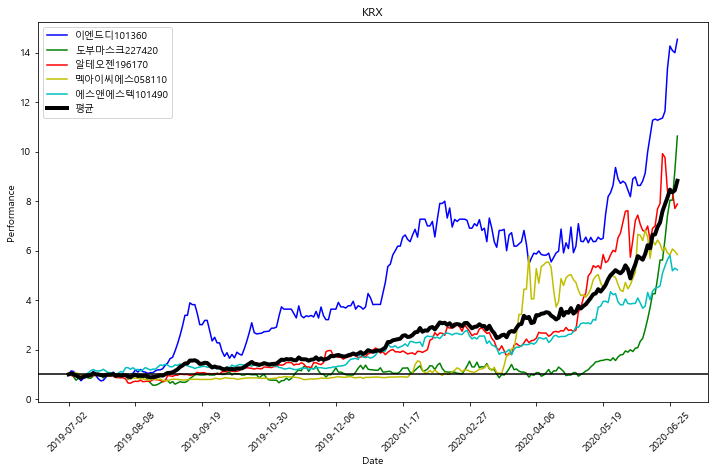

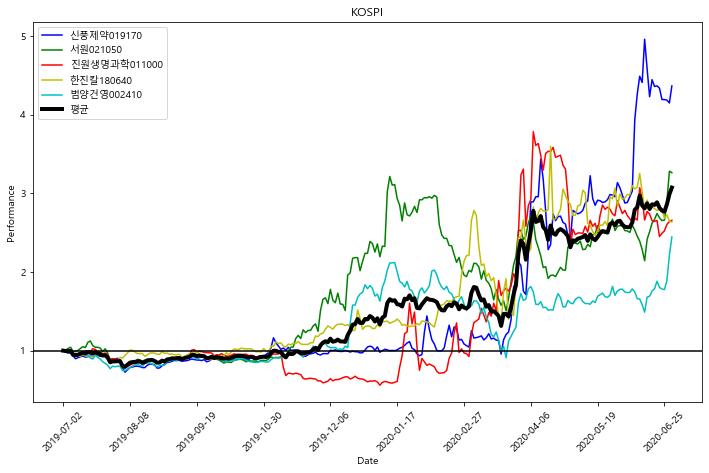

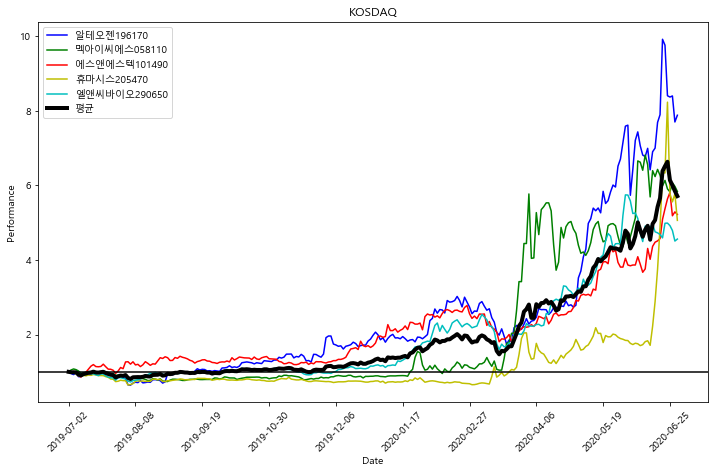

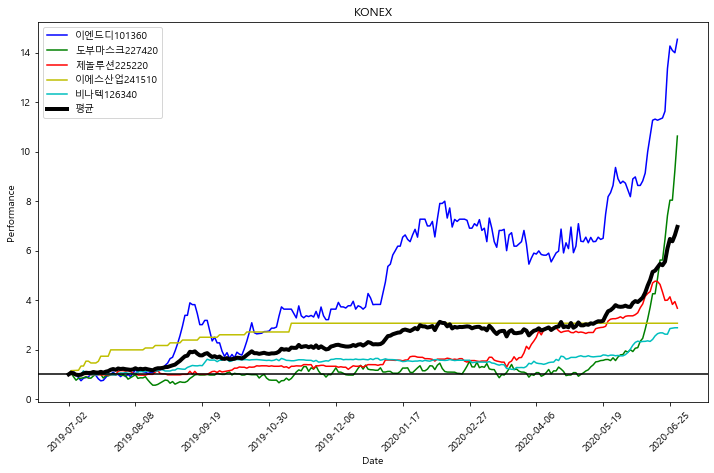

In [24]:
# Yield 기준 추천 5개
try:
    perfomanceEvaluation(krxRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KRX"))
except:
    pass
try:
    perfomanceEvaluation(kospiRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KOSPI"))
except:
    pass
try:
    perfomanceEvaluation(kosdaqRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KOSDAQ"))
except:
    pass
try:
    perfomanceEvaluation(konexRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KONEX"))
except:
    pass

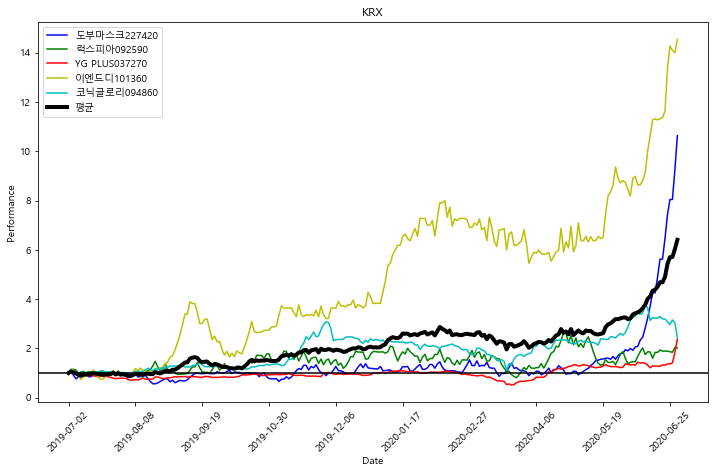

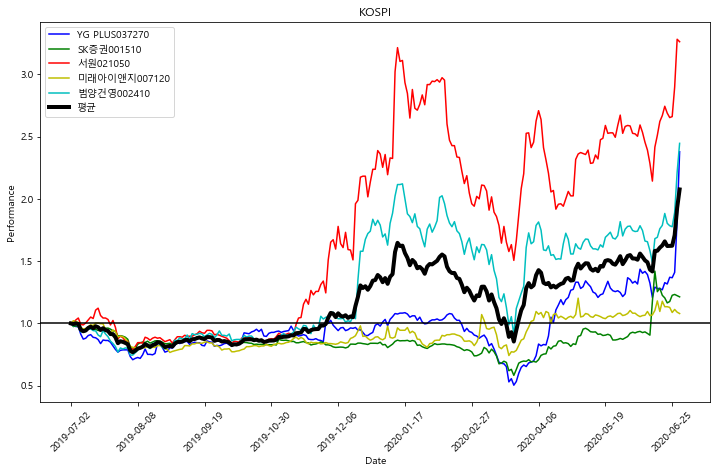

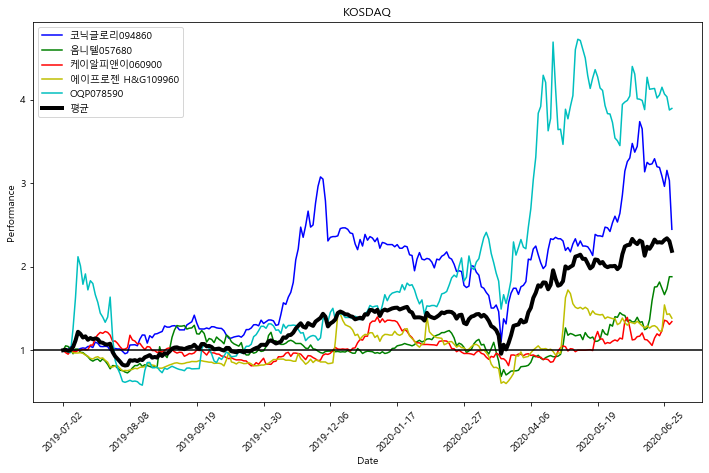

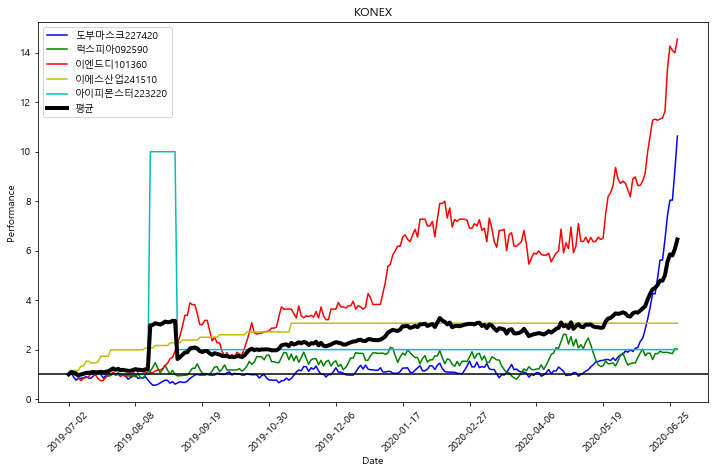

In [25]:
# AdjustedYield 기준 추천 5개
try:
    perfomanceEvaluation(krxRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KRX"))
except:
    pass
try:
    perfomanceEvaluation(kospiRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KOSPI"))
except:
    pass
try:    
    perfomanceEvaluation(kosdaqRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KOSDAQ"))
except:
    pass
try:    
    perfomanceEvaluation(konexRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KONEX"))
except:
    pass

### 4. 테스트용 추천종목 5개 선별 (KRX, KOSPI, KOSDAQ, KONEX, 보통주식) : 2년 전 ~ 1년 전 기준

In [26]:
testTickersDF = getTickersDF(731)
testTickersDF.tail(1)

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
2102,238490,KOSDAQ,힘스,특수 목적용 기계 제조업,"OLED Mask 인장기, OLED Mask 검사기 등",2017-07-20,12월,김주환,http://www.hims.co.kr,인천광역시


In [27]:
testPositiveTickersDF = getMomentum(tickersDF, testStartDate, testEndDate)

C:\Users\kkuno\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [28]:
testKrxRcmdDFByYield = getRcmdDFByYield(testTickersDF, testPositiveTickersDF, "KRX")
testKospiRcmdDFByYield = getRcmdDFByYield(testTickersDF, testPositiveTickersDF, "KOSPI")
testKosdaqRcmdDFByYield = getRcmdDFByYield(testTickersDF, testPositiveTickersDF, "KOSDAQ")
testKonexRcmdDFByYield = getRcmdDFByYield(testTickersDF, testPositiveTickersDF, "KONEX")

In [29]:
testKrxRcmdDFByAdjYield = getRcmdDFByAdjustedYield(testTickersDF, testPositiveTickersDF, "KRX")
testKospiRcmdDFByAdjYield = getRcmdDFByAdjustedYield(testTickersDF, testPositiveTickersDF, "KOSPI")
testKosdaqRcmdDFByAdjYield = getRcmdDFByAdjustedYield(testTickersDF, testPositiveTickersDF, "KOSDAQ")
testKonexRcmdDFByAdjYield = getRcmdDFByAdjustedYield(testTickersDF, testPositiveTickersDF, "KONEX")

### 5. 테스트용 종목의 성과 평가(전략의 유효성 검증) : 1년 전 ~ 현재

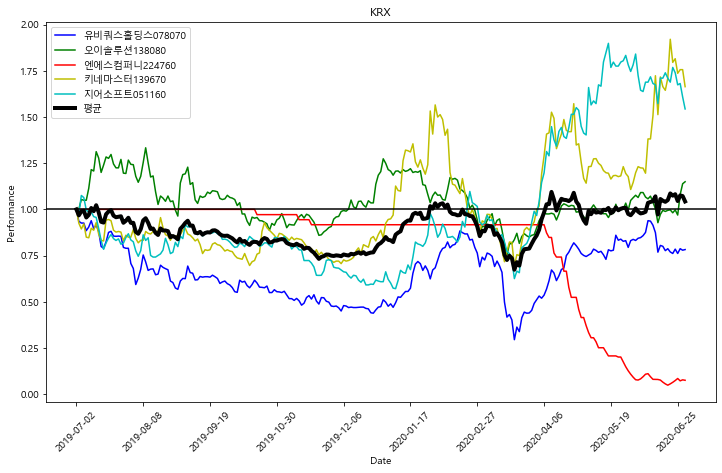

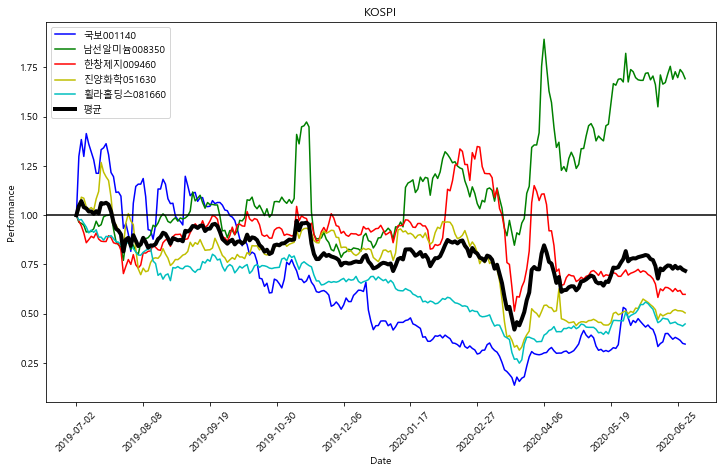

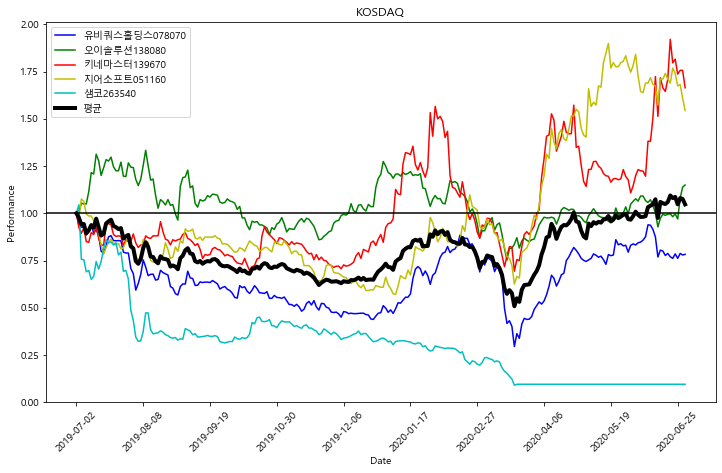

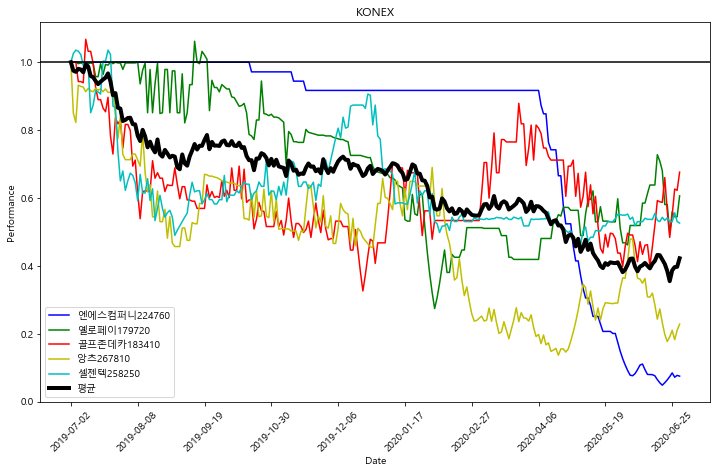

In [30]:
# Yield 기준 성과 테스트
try:
    perfomanceEvaluation(testKrxRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KRX_Test"))
except:
    pass
try:
    perfomanceEvaluation(testKospiRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KOSPI_Test"))
except:
    pass
try:
    perfomanceEvaluation(testKosdaqRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KOSDAQ_Test"))
except:
    pass
try:
    perfomanceEvaluation(testKonexRcmdDFByYield, startDate, endDate, (today + "Factor_Momentum_LT_Yield_KONEX_Test"))
except:
    pass

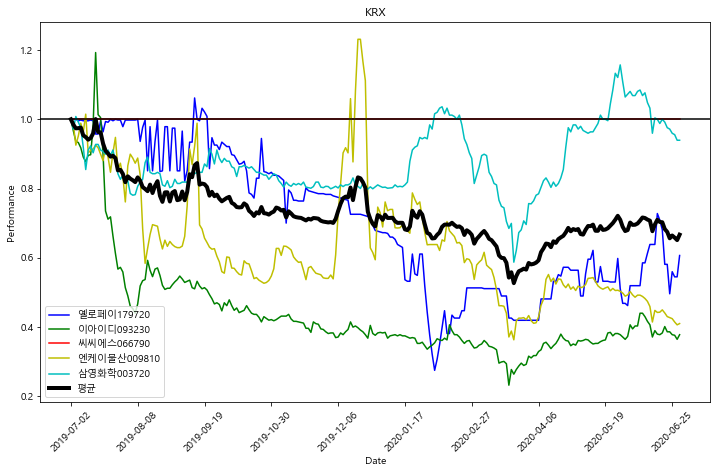

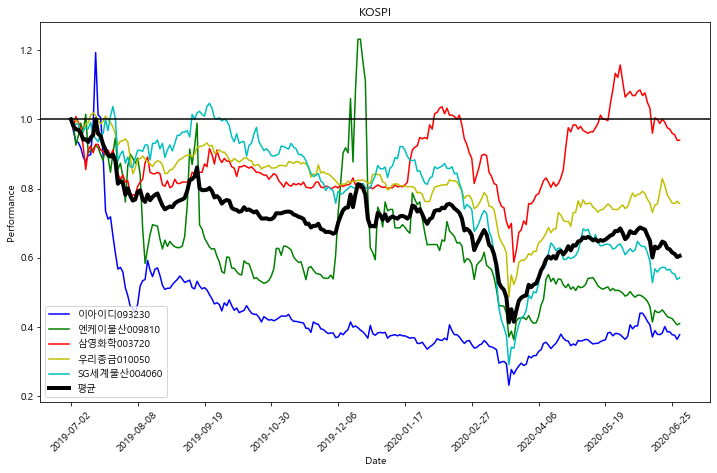

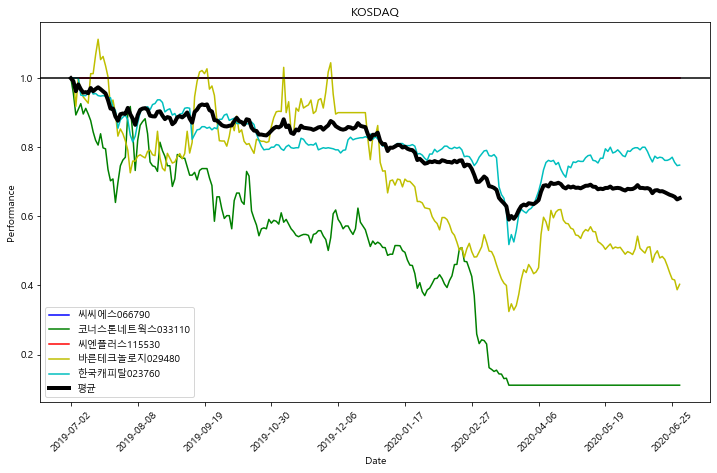

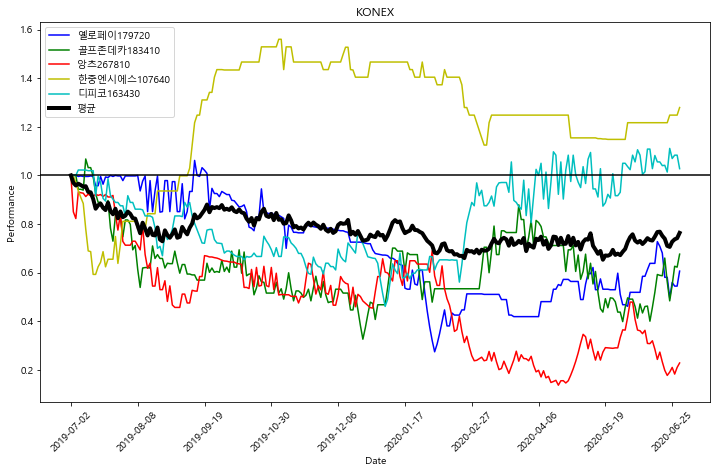

In [31]:
# AdjustedYield 기준 성과 테스트
try:
    perfomanceEvaluation(testKrxRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KRX_Test"))
except:
    pass
try:
    perfomanceEvaluation(testKospiRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KOSPI_Test"))
except:
    pass
try:
    perfomanceEvaluation(testKosdaqRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KOSDAQ_Test"))
except:
    pass
try:
    perfomanceEvaluation(testKonexRcmdDFByAdjYield, startDate, endDate, (today + "Factor_Momentum_LT_AdjYield_KONEX_Test"))
except:
    pass